In [145]:
from google.colab import files
uploaded = files.upload()

Saving AEP_hourly.csv to AEP_hourly (2).csv


Long Short Term Memory (LSTM)

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [148]:
# 1. Load Dataset
df = pd.read_csv("AEP_hourly.csv", parse_dates=['Datetime'])
df.sort_values("Datetime", inplace=True)
df.set_index("Datetime", inplace=True)

In [149]:
# 2. Ubah ke data harian (menjumlahkan konsumsi tiap hari)
df_daily = df.resample('D').sum()

In [150]:
# 3. Membagi Train dan Test
train = df_daily[df_daily.index < '2014-01-01']
test = df_daily[df_daily.index >= '2014-01-01']

In [151]:
# 4. Normalisasi
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['AEP_MW']])
test_scaled = scaler.transform(test[['AEP_MW']])

In [152]:
# 5. Fungsi membuat sequence data
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

In [153]:
# Buat data sequence untuk training dan testing
time_steps = 30
X_train, y_train = create_sequences(train_scaled, time_steps)
X_test, y_test = create_sequences(test_scaled, time_steps)
# Timesteps 30 -> melihat data 30 hari sebelumnya untuk memprediksi 1 hari

# Ubah shape ke 3D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# menyesuaikan format input yang dibutuhkan oleh model LSTM di TensorFlow/Keras.

In [166]:
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
# 50 unit neuron

model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0222
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0130
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0108
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0084
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0067
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0066
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0053
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0050
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0049
Epoch 10/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0049
Epoch 11/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0045
Epoch 12/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0047
Epoch 13/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0046
Epoch 14/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0046
Epoch 15/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step 

In [167]:
predicted = model.predict(X_test)

# Balikkan skala ke nilai asli
predicted_unscaled = scaler.inverse_transform(predicted)
y_test_unscaled = scaler.inverse_transform(y_test)

# Hitung RMSE
rmse = sqrt(mean_squared_error(y_test_unscaled, predicted_unscaled))
print("RMSE LSTM:", rmse)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE LSTM: 19963.980226408636


In [168]:
print("Model Performance Summary")
print(f"RMSE LSTM: {rmse:.2f} MW")
print(f"Persentase Error: {(rmse / test_data.mean()) * 100:.2f}% dari rata-rata konsumsi harian")

Model Performance Summary
RMSE LSTM: 19963.98 MW
Persentase Error: 5.59% dari rata-rata konsumsi harian


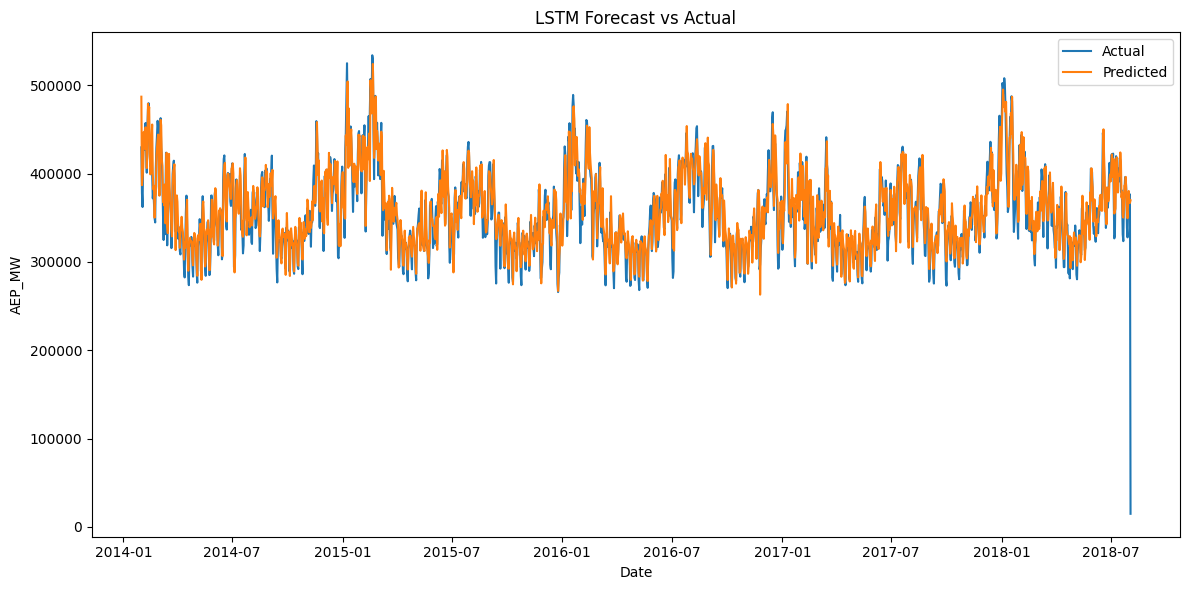

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test.index[time_steps:], y_test_unscaled, label='Actual')
plt.plot(test.index[time_steps:], predicted_unscaled, label='Predicted')
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("AEP_MW")
plt.legend()
plt.tight_layout()
plt.show()

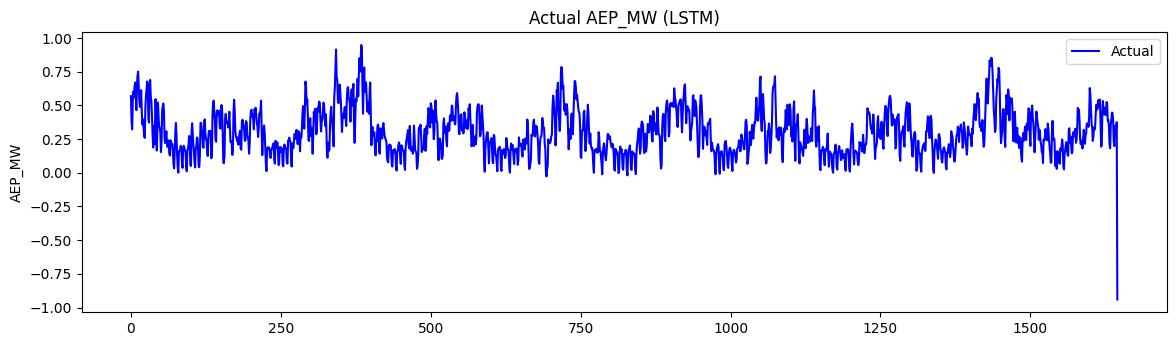

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Subplot 1: Data Aktual
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual', color='blue')
plt.title("Actual AEP_MW (LSTM)")
plt.ylabel("AEP_MW")
plt.legend()

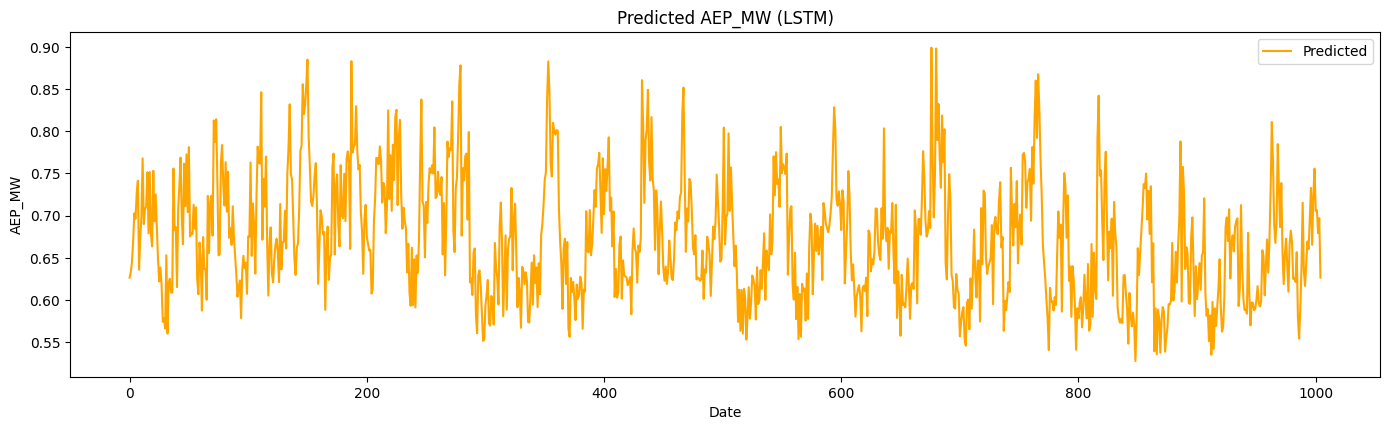

In [ ]:
# Subplot 2: Data Prediksi
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 2)
plt.plot(y_pred, label='Predicted', color='orange')
plt.title("Predicted AEP_MW (LSTM)")
plt.xlabel("Date")
plt.ylabel("AEP_MW")
plt.legend()

plt.tight_layout()
plt.show()

Melihat Overfitting atau Tidak

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,  # gunakan 20% data training sebagai validation
    verbose=1
)


Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 12/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 

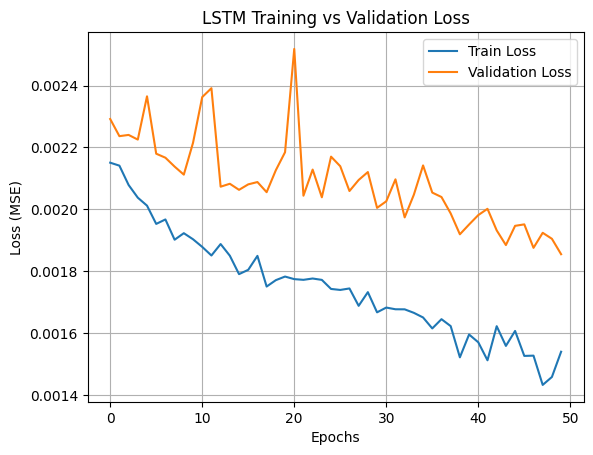

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Sudah hitung sebelumnya
rmse_test = 20853.74
rmse_train = 10500.22  # (misal kamu hitung manual di train set)

print(f"Train RMSE: {rmse_train}")
print(f"Test RMSE: {rmse_test}")


Train RMSE: 10500.22
Test RMSE: 20853.74


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
df = pd.read_csv('AEP_hourly.csv', parse_dates=['Datetime'], index_col='Datetime')

# Agregasi harian
df_daily = df.resample('D').sum()

# Split data
train_data = df_daily[df_daily.index < '2014-01-01']['AEP_MW']
test_data = df_daily[df_daily.index >= '2014-01-01']['AEP_MW']


In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_test = scaler.transform(test_data.values.reshape(-1, 1))

# Buat window time series
def create_sequences(data, timesteps=30):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

timesteps = 30
X_train, y_train = create_sequences(scaled_train, timesteps)
X_test, y_test = create_sequences(scaled_test, timesteps)

# Reshape ke 3D
X_train = X_train.reshape((X_train.shape[0], timesteps, 1))
X_test = X_test.reshape((X_test.shape[0], timesteps, 1))


In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(timesteps, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0293
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0149
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0153
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0143
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0111
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0095
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0087
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0087
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0081
Epoch 10/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0077
Epoch 11/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0073
Epoch 12/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0069
Epoch 13/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0067
Epoch 14/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0063
Epoch 15/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 

In [ ]:
predicted = model.predict(X_test)

# Inverse transform
predicted_unscaled = scaler.inverse_transform(predicted)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# RMSE
rmse = sqrt(mean_squared_error(y_test_unscaled, predicted_unscaled))
print("RMSE LSTM:", rmse)

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
RMSE LSTM: 20693.247648087196


In [ ]:
print("Model Performance Summary")
print(f"RMSE LSTM: {rmse:.2f} MW")
print(f"Persentase Error: {(rmse / test_data.mean()) * 100:.2f}% dari rata-rata konsumsi harian testing")

Model Performance Summary
RMSE LSTM: 20693.25 MW
Persentase Error: 5.80% dari rata-rata konsumsi harian testing


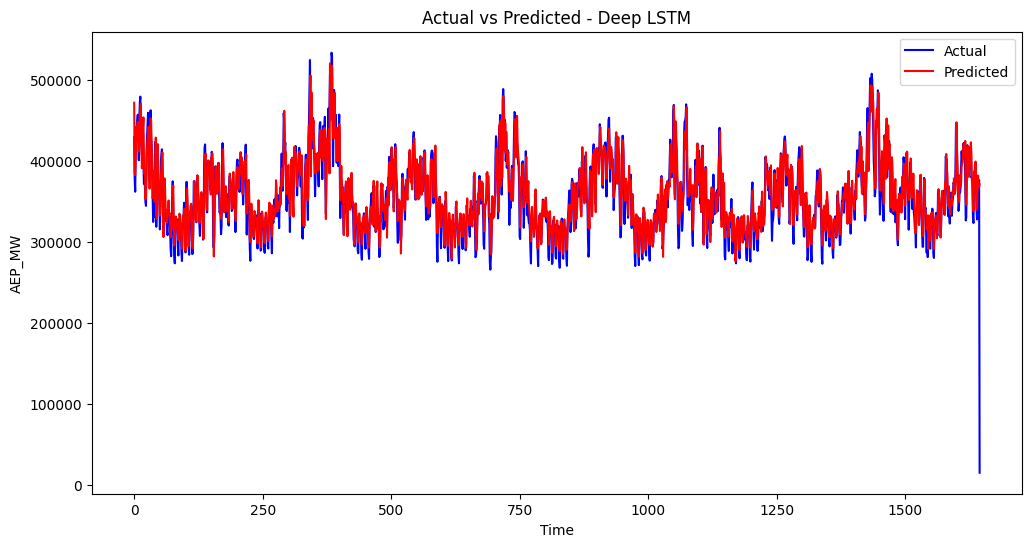

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled, label='Actual', color='blue')
plt.plot(predicted_unscaled, label='Predicted', color='red')
plt.title("Actual vs Predicted - Deep LSTM")
plt.xlabel("Time")
plt.ylabel("AEP_MW")
plt.legend()
plt.show()